<a href="https://colab.research.google.com/github/Orphy123/AITDeepLearning/blob/main/AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer



## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [3]:
url1 = "https://www.gutenberg.org/files/1342/1342-0.txt" # Pride and Prejudice by Jane Austen
url2 = "https://www.gutenberg.org/files/11/11-0.txt" # Alice's Adventures in Wonderland by Lewis Carroll

urllib.request.urlretrieve(url1, 'author1.txt')
urllib.request.urlretrieve(url2, 'author2.txt')


('author2.txt', <http.client.HTTPMessage at 0x7fb2c9066970>)

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

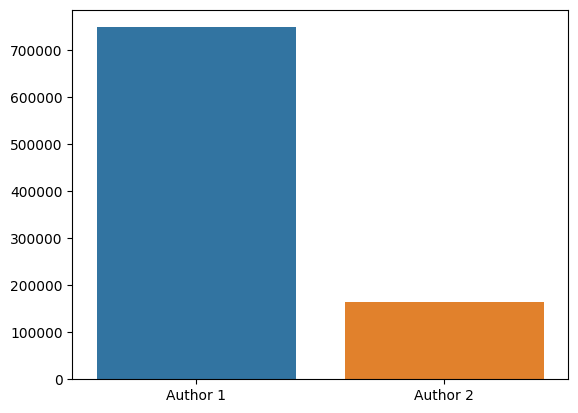

In [4]:
def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

author1_text = load_text('author1.txt')
author2_text = load_text('author2.txt')

author1_chars = len(author1_text)
author2_chars = len(author2_text)

sns.barplot(x=['Author 1', 'Author 2'], y=[author1_chars, author2_chars])
plt.show()



## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [5]:
def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

author1_text = load_text('author1.txt')
author2_text = load_text('author2.txt')

# combine texts and create mapping of unique characters to integers
combined_text = author1_text + author2_text
unique_chars = sorted(list(set(combined_text)))
char_to_int = dict((c, i) for i, c in enumerate(unique_chars))

# generate sequences with sliding window approach and assign labels
sequences = []
labels = []
seq_length = 60
for i in range(0, len(combined_text) - seq_length, 10):
    seq = combined_text[i:i+seq_length]
    label = 0 if i < len(author1_text) else 1
    sequences.append([char_to_int[char] for char in seq])
    labels.append(label)

# convert sequences and labels to numpy arrays
sequences = np.array(sequences)
labels = to_categorical(labels)

# convert characters to one-hot encodings
alphabet_length = len(unique_chars)
one_hot_sequences = np.zeros((len(sequences), seq_length, alphabet_length), dtype=np.bool)
for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        one_hot_sequences[i, t, char] = 1


<ipython-input-5-71a393245799>:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  one_hot_sequences = np.zeros((len(sequences), seq_length, alphabet_length), dtype=np.bool)


## Data splitting
Split the data into train, validate and test sets. Make 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [7]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, alphabet_length)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Model training
Train the model and apply early stopping.

In [8]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=12, batch_size=32, callbacks=callbacks)

# evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.3f}\nTest accuracy: {accuracy:.3f}')


Epoch 1/12
1825/1825 [==============================] - 121s 64ms/step - loss: 0.2581 - accuracy: 0.9001 - val_loss: 0.1849 - val_accuracy: 0.9260
Epoch 2/12
1825/1825 [==============================] - 114s 63ms/step - loss: 0.1540 - accuracy: 0.9400 - val_loss: 0.1731 - val_accuracy: 0.9381
Epoch 3/12
1825/1825 [==============================] - 114s 62ms/step - loss: 0.1155 - accuracy: 0.9547 - val_loss: 0.1060 - val_accuracy: 0.9564
Epoch 4/12
1825/1825 [==============================] - 114s 62ms/step - loss: 0.0878 - accuracy: 0.9650 - val_loss: 0.1075 - val_accuracy: 0.9585
Epoch 5/12
1825/1825 [==============================] - 118s 65ms/step - loss: 0.0695 - accuracy: 0.9728 - val_loss: 0.0815 - val_accuracy: 0.9677
Epoch 6/12
1825/1825 [==============================] - 113s 62ms/step - loss: 0.0575 - accuracy: 0.9775 - val_loss: 0.0667 - val_accuracy: 0.9752
Epoch 7/12
1825/1825 [==============================] - 119s 65ms/step - loss: 0.0475 - accuracy: 0.9816 - val_loss: 0

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")


571/571 [==============================] - 6s 11ms/step - loss: 0.0602 - accuracy: 0.9794
Loss: 0.0602
Accuracy: 0.9794


## Confusion matrix
Calculate and display the confusion matrix.

571/571 [==============================] - 7s 11ms/step


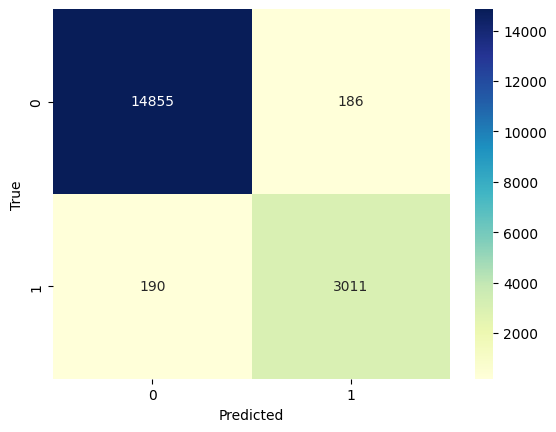

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15041
           1       0.94      0.94      0.94      3201

    accuracy                           0.98     18242
   macro avg       0.96      0.96      0.96     18242
weighted avg       0.98      0.98      0.98     18242



In [10]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred))
